<a href="https://colab.research.google.com/github/0530hwi/KaggleStudy/blob/main/Recruit_Restaurant_Visitor_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 파일 설명

- air_visit_data.csv: air restaurants의 과거 방문 data. main training data set이다.
- air_reserve.csv / hpg_reserve.csv: air & hpg 레스토랑 예약 시스템
- air_store_info.csv / hpg_store_info.csv: air & hpg 레스토랑 세부 정보
- store_id_relation.csv: air & hpg id
- date_info.csv: 일본 공휴일 정보
- sample_submission.csv: test set으로 사용. ’id’는 air id와 방문 날짜를 결합하여 생성


[Kaggle Overview](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview)

Kaggle code 참고 자료

- [Restaurant Visitor Forecasting EDA with R (한글 번역)](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r)
- [Surprise Me 2!](https://www.kaggle.com/tunguz/surprise-me-2)

# 1. 준비(Preparations)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 데이터 불러오기
air_visits_history = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/air_visit_data.csv')
air_reserve = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/air_reserve.csv')
hpg_reserve = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/hpg_reserve.csv')
air_store_info = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/air_store_info.csv')
hpg_store_info = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/hpg_store_info.csv')
holidays  = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/date_info.csv')
store_ids = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/store_id_relation.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab/제 1차 해커톤(강남)/sample_submission.csv')

In [ ]:
print("air_visits_history.shape : ", air_visits_history.shape)
print("air_reserve.shape : ", air_reserve.shape)
print("hpg_reserve.shape : ", hpg_reserve.shape)
print("air_store_info.shape : ", air_store_info.shape)
print("hpg_store_info.shape : ", hpg_store_info.shape)
print("holidays.shape : ", holidays.shape)
print("store_ids.shape : ", store_ids.shape)
print("test.shape : ", test.shape)

air_visits_history.shape :  (252108, 3)
air_reserve.shape :  (92378, 4)
hpg_reserve.shape :  (2000320, 4)
air_store_info.shape :  (829, 5)
hpg_store_info.shape :  (4690, 5)
holidays.shape :  (517, 3)
store_ids.shape :  (150, 2)
test.shape :  (32019, 2)


In [ ]:
# 결측값 확인
print("air_visits_history의 결측값 갯수 : \n", air_visits_history.isnull().sum())
print("air_reserve의 결측값 갯수 : \n", air_reserve.isnull().sum())
print("hpg_reserve의 결측값 갯수 : \n", hpg_reserve.isnull().sum())
print("air_store_info의 결측값 갯수 : \n", air_store_info.isnull().sum())
print("hpg_store_info의 결측값 갯수 : \n", hpg_store_info.isnull().sum())
print("holidays의 결측값 갯수 : \n", holidays.isnull().sum())
print("store_ids의 결측값 갯수 : \n", store_ids.isnull().sum())
print("test.shape의 결측값 갯수 : \n", test.isnull().sum())

air_visits_history의 결측값 갯수 : 
 air_store_id    0
visit_date      0
visitors        0
dtype: int64
air_reserve의 결측값 갯수 : 
 air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
hpg_reserve의 결측값 갯수 : 
 hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
air_store_info의 결측값 갯수 : 
 air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64
hpg_store_info의 결측값 갯수 : 
 hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64
holidays의 결측값 갯수 : 
 calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64
store_ids의 결측값 갯수 : 
 air_store_id    0
hpg_store_id    0
dtype: int64
test.shape의 결측값 갯수 : 
 id          0
visitors    0
dtype: int64


---------
전처리(데이터 분할 시도)

In [ ]:
air_visits_history.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
air_visits_history.dtypes

air_store_id    object
visit_date      object
visitors         int64
dtype: object

In [ ]:
# visit_data 를 year, month, day로 분할
air_visits_history["year"] = air_visits_history["visit_date"].str[:4]
air_visits_history["month"] = air_visits_history["visit_date"].str[5:7]
air_visits_history["day"] = air_visits_history["visit_date"].str[8:]

air_visits_history["year"] = pd.to_numeric(air_visits_history["year"])
air_visits_history["month"] = pd.to_numeric(air_visits_history["month"])
air_visits_history["day"] = pd.to_numeric(air_visits_history["day"])

air_visits_history.dtypes

air_store_id    object
visit_date      object
visitors         int64
year             int64
month            int64
day              int64
dtype: object

In [ ]:
is_visit_2016 = air_visits_history["year"] == 2016
is_visit_2017 = air_visits_history["year"] == 2017

visitor_2016 = air_visits_history[is_visit_2016]
visitor_2017 = air_visits_history[is_visit_2017]

In [ ]:
visitor_2016

,air_store_id,visit_date,visitors,year,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18
...,...,...,...,...,...,...
252013,air_24e8414b9b07decb,2016-12-26,7,2016,12,26
252014,air_24e8414b9b07decb,2016-12-27,6,2016,12,27
252015,air_24e8414b9b07decb,2016-12-28,8,2016,12,28
252016,air_24e8414b9b07decb,2016-12-29,2,2016,12,29


In [ ]:
# 년도별 groupby
grouped = visitor_2016['visitors'].groupby(visitor_2016['month'])
monthly_visitor_2016 = grouped.sum()
grouped = visitor_2017['visitors'].groupby(visitor_2017['month'])
monthly_visitor_2017 = grouped.sum(0)

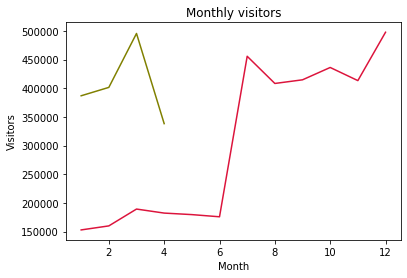

In [ ]:
plt.plot(monthly_visitor_2016, color = 'crimson')#,#marker ='o', linestyle='-')
plt.plot(monthly_visitor_2017, color='olive')#, maker='s', linestype='-')
plt.title('Monthly visitors')
plt.xlabel('Month')
plt.ylabel('Visitors')
plt.show()

In [ ]:
# 가계별 방문객 수
grouped = air_visits_history['visitors'].groupby(air_visits_history['air_store_id'])
grouped.sum() # air store 수는 829개

air_store_id
air_00a91d42b08b08d9    6051
air_0164b9927d20bcc3    1378
air_0241aa3964b7f861    3919
air_0328696196e46f18     921
air_034a3d5b40d5b1b1    3722
                        ... 
air_fea5dc9594450608    3969
air_fee8dcf4d619598e    7496
air_fef9ccb3ba0da2f7    2357
air_ffcc2d5087e1b476    4919
air_fff68b929994bfbd    1369
Name: visitors, Length: 829, dtype: int64

In [ ]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [ ]:
# date & time 분리
date_split = air_reserve["visit_datetime"].str.split(" ")

air_reserve["visit_date"] = date_split.str.get(0)
air_reserve["visit_time"] = date_split.str.get(1)

# 세부 년/월/일/시/분/초 분할
air_reserve["year"] = air_reserve["visit_date"].str[:4]
air_reserve["month"] = air_reserve["visit_date"].str[5:7]
air_reserve["day"] = air_reserve["visit_date"].str[8:]

air_reserve["year"] = pd.to_numeric(air_reserve["year"])
air_reserve["month"] = pd.to_numeric(air_reserve["month"])
air_reserve["day"] = pd.to_numeric(air_reserve["day"])

air_reserve["hour"] = air_reserve["visit_time"].str[:2]
air_reserve["minuate"] = air_reserve["visit_time"].str[3:5]
air_reserve["second"] = air_reserve["visit_time"].str[6:]

air_reserve["hour"] = pd.to_numeric(air_reserve["hour"])
air_reserve["minuate"] = pd.to_numeric(air_reserve["minuate"])
air_reserve["second"] = pd.to_numeric(air_reserve["second"])

air_reserve.dtypes

air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
visit_date          object
visit_time          object
year                 int64
month                int64
day                  int64
hour                 int64
minuate              int64
second               int64
dtype: object

In [ ]:
# 분/초 모두 0 으로 minuate, second columns drop
air_reserve.drop(['minuate', 'second'], axis=1, inplace=True)

In [ ]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [ ]:
air_store_info.dtypes

air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object

In [ ]:
area_split = air_store_info["air_area_name"].str.split(" ")
air_store_info["todobuken"] = area_split.str.get(0)
air_store_info["city"] = area_split.str.get(1)

In [ ]:
grouped = air_store_info['air_store_id'].groupby(air_store_info['air_genre_name'])
grouped.count()

air_genre_name
Asian                             2
Bar/Cocktail                     79
Cafe/Sweets                     181
Creative cuisine                 13
Dining bar                      108
International cuisine             2
Italian/French                  102
Izakaya                         197
Japanese food                    63
Karaoke/Party                     2
Okonomiyaki/Monja/Teppanyaki     14
Other                            27
Western food                     16
Yakiniku/Korean food             23
Name: air_store_id, dtype: int64

In [ ]:
grouped = air_store_info['air_store_id'].groupby(air_store_info['longitude'])
grouped.count()

longitude
130.195555     7
130.348436     6
130.350764     2
130.369976     4
130.392813    62
              ..
141.353957     2
141.474789     2
142.364819    13
143.197959     2
144.273398     2
Name: air_store_id, Length: 108, dtype: int64

In [ ]:
grouped = air_store_info['air_store_id'].groupby(air_store_info["todobuken"])
air_city = grouped.count()

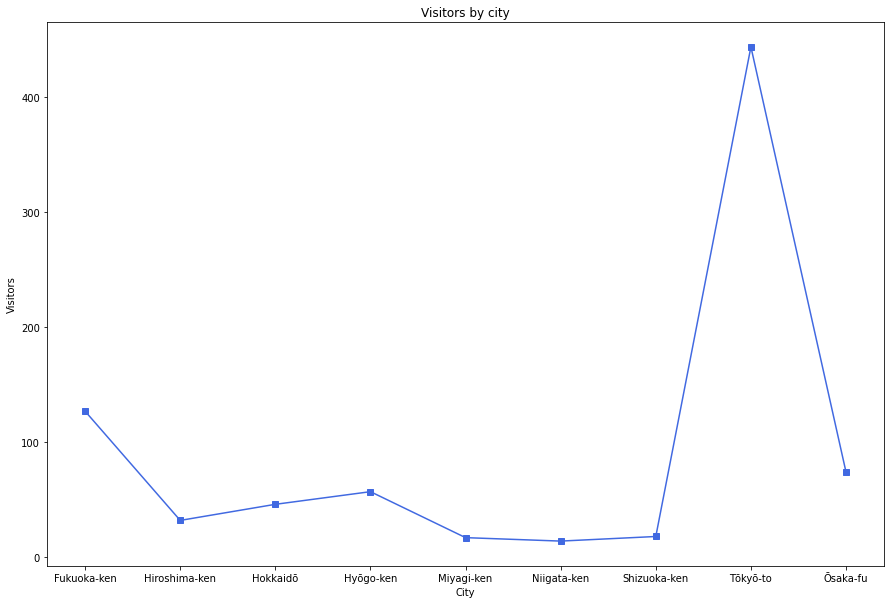

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(air_city, color = 'royalblue', marker ='s', linestyle='-')
plt.title('Visitors by city')
plt.xlabel('City')
plt.ylabel('Visitors')
plt.show()

In [ ]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [ ]:
hpg_reserve.dtypes

hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [ ]:
visit_split = hpg_reserve["visit_datetime"].str.split(" ")
reserve_split = hpg_reserve["reserve_datetime"].str.split(" ")

hpg_reserve["visit_date"] = visit_split.str.get(0)
hpg_reserve["visit_time"] = visit_split.str.get(1)
hpg_reserve["reserve_date"] = reserve_split.str.get(0)
hpg_reserve["reserve_time"] = reserve_split.str.get(1)

In [ ]:
# 세부 년/월/일/시/분/초 분할
hpg_reserve["year_v"] = hpg_reserve["visit_date"].str[:4]
hpg_reserve["month_v"] = hpg_reserve["visit_date"].str[5:7]
hpg_reserve["day_v"] = hpg_reserve["visit_date"].str[8:]
hpg_reserve["hour_v"] = hpg_reserve["visit_time"].str[:2]

hpg_reserve["year_v"] = pd.to_numeric(hpg_reserve["year_v"])
hpg_reserve["month_v"] = pd.to_numeric(hpg_reserve["month_v"])
hpg_reserve["day_v"] = pd.to_numeric(hpg_reserve["day_v"])
hpg_reserve["hour_v"] = pd.to_numeric(hpg_reserve["hour_v"])

hpg_reserve["year_r"] = hpg_reserve["reserve_date"].str[:4]
hpg_reserve["month_r"] = hpg_reserve["reserve_date"].str[5:7]
hpg_reserve["day_r"] = hpg_reserve["reserve_date"].str[8:]
hpg_reserve["hour_r"] = hpg_reserve["reserve_time"].str[:2]

hpg_reserve["year_r"] = pd.to_numeric(hpg_reserve["year_r"])
hpg_reserve["month_r"] = pd.to_numeric(hpg_reserve["month_r"])
hpg_reserve["day_r"] = pd.to_numeric(hpg_reserve["day_r"])
hpg_reserve["hour_r"] = pd.to_numeric(hpg_reserve["hour_r"])

In [ ]:
# visit_date외 reserve_date가 다른 경우
is_diff_day = hpg_reserve["visit_date"] != hpg_reserve["reserve_date"]

diff_day = hpg_reserve[is_diff_day]
diff_day.count()

# 몇일 전에 예약하는 사람이 실제 방문하게 될지 여부 찾아볼 것.

hpg_store_id        1812112
visit_datetime      1812112
reserve_datetime    1812112
reserve_visitors    1812112
visit_date          1812112
visit_time          1812112
reserve_date        1812112
reserve_time        1812112
year_v              1812112
month_v             1812112
day_v               1812112
hour_v              1812112
year_r              1812112
month_r             1812112
day_r               1812112
hour_r              1812112
dtype: int64

In [ ]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [ ]:
hpg_store_info.dtypes

hpg_store_id       object
hpg_genre_name     object
hpg_area_name      object
latitude          float64
longitude         float64
dtype: object

In [ ]:
grouped = hpg_store_info['hpg_store_id'].groupby(hpg_store_info['hpg_genre_name'])
grouped.count()

hpg_genre_name
Amusement bar                      5
Bar/Cocktail                       7
Bistro                            22
Cafe                              16
Cantonese food                     4
Chinese general                   91
Creation                         410
Creative Japanese food            60
Dim Sum/Dumplings                  2
French                            27
Grilled meat                     325
International cuisine            700
Italian                          249
Japanese cuisine/Kaiseki          64
Japanese food in general          85
Japanese style                  1750
Karaoke                           60
Korean cuisine                    38
Okonomiyaki/Monja/Teppanyaki      44
Party                             40
Pasta/Pizza                       10
Seafood                          339
Shabu-shabu/Sukiyaki              59
Shanghai food                      1
Sichuan food                       3
Spain Bar/Italian Bar            229
Spain/Mediterranean cui

In [ ]:
area_split = hpg_store_info["hpg_area_name"].str.split(" ")
hpg_store_info["todobuken"] = area_split.str.get(0)
hpg_store_info["city"] = area_split.str.get(1)

In [ ]:
grouped = hpg_store_info['hpg_store_id'].groupby(hpg_store_info['todobuken'])
hpg_city = grouped.count()

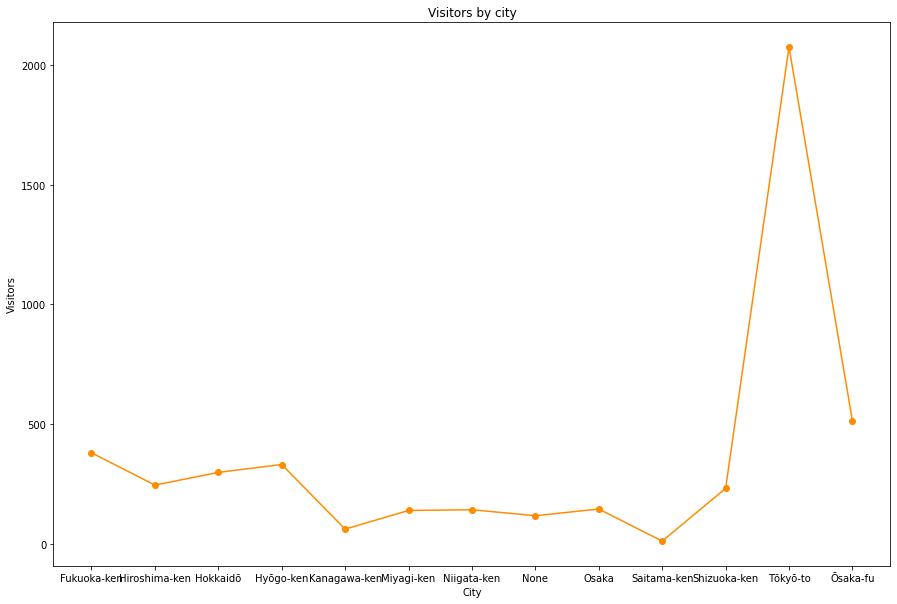

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(hpg_city, color = 'darkorange', marker ='o', linestyle='-')
plt.title('Visitors by city')
plt.xlabel('City')
plt.ylabel('Visitors')
plt.show()

In [ ]:
store_ids.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [ ]:
store_ids.dtypes

air_store_id    object
hpg_store_id    object
dtype: object

In [ ]:
holidays

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [ ]:
holidays.dtypes

calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object

In [ ]:
grouped = holidays['calendar_date'].groupby(holidays['holiday_flg'])
grouped.count() # 2016-01-01 ~2017- 05-31 중 공휴일 수 35일

holiday_flg
0    482
1     35
Name: calendar_date, dtype: int64

In [ ]:
test

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0
32015,air_fff68b929994bfbd_2017-05-28,0
32016,air_fff68b929994bfbd_2017-05-29,0
32017,air_fff68b929994bfbd_2017-05-30,0


In [ ]:
test.dtypes

id          object
visitors     int64
dtype: object

------

# 2. 데이터 merge & join

In [ ]:
air = pd.merge(air_reserve, air_store_info, on='air_store_id', how='inner')
display(air.head(3), air.shape, air['air_store_id'].unique().shape)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


(92378, 8)

(314,)

In [ ]:
hpg = pd.merge(hpg_reserve, hpg_store_info, on='hpg_store_id', how='inner')
display(hpg.head(3), hpg.shape, hpg['hpg_store_id'].unique().shape)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


(871308, 8)

(4690,)

In [ ]:
store_ids.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [ ]:
#I'm assuming that air stores which are also listed in hpg have mutually exclusive bookings through air and hpg portal. 
#As we are forecasting on air stores only, we'll pull information for those specific stores from the hpg dataset. 
#For that we'll first jpin hpg dataset with store relation dataset to pull corresponding air store ids

In [ ]:
hpg = pd.merge(store_ids, hpg, on='hpg_store_id', how='inner')
display(hpg.head(3), hpg.shape)

,air_store_id,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,air_a24bf50c3e90d583,hpg_c34b496d0305a809,2016-01-06 19:00:00,2016-01-06 13:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809,2016-01-07 21:00:00,2016-01-03 19:00:00,6,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
2,air_a24bf50c3e90d583,hpg_c34b496d0305a809,2016-01-08 19:00:00,2016-01-07 14:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944


(13528, 9)

In [ ]:
hpg = hpg.drop(['hpg_store_id'],axis =1) #don't require hpg_id now
display(hpg.head(3), hpg.shape)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,air_a24bf50c3e90d583,2016-01-06 19:00:00,2016-01-06 13:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
1,air_a24bf50c3e90d583,2016-01-07 21:00:00,2016-01-03 19:00:00,6,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
2,air_a24bf50c3e90d583,2016-01-08 19:00:00,2016-01-07 14:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944


(13528, 8)

In [ ]:
hpg.rename(columns={'hpg_genre_name': 'air_genre_name', \
                    'hpg_area_name': 'air_area_name'}, inplace=True)
#renaming column names to match up with the air_combine dataset
display(hpg.head(3), hpg.shape)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_a24bf50c3e90d583,2016-01-06 19:00:00,2016-01-06 13:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
1,air_a24bf50c3e90d583,2016-01-07 21:00:00,2016-01-03 19:00:00,6,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
2,air_a24bf50c3e90d583,2016-01-08 19:00:00,2016-01-07 14:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944


(13528, 8)

In [ ]:
print(air.shape)
print(hpg.shape)

(92378, 8)
(13528, 8)


In [ ]:
display(hpg.tail(3), hpg.shape)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
13525,air_465bddfed3353b23,2017-04-27 18:00:00,2017-04-18 09:00:00,4,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924
13526,air_465bddfed3353b23,2017-04-28 19:00:00,2017-04-19 13:00:00,15,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924
13527,air_465bddfed3353b23,2017-05-02 19:00:00,2017-04-12 21:00:00,2,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924


(13528, 8)

In [ ]:
air = pd.concat([air, hpg],axis = 0) #combining data for air stores from both datasets
display(air.head(), air.shape)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


(105906, 8)

* 단계별로 생각해보자❗

1. `air_reverse`, `air_store_info`를 `air_store_id` 기준으로 병합함<br>
`hpg_reverse`, `hpg_store_info`도 마찬가지이다.

2. `store_id_relation`과 새롭게 만들어진 `hpg`데이터 병합<br>
`test data`가 `air_store_id`기준으로 만들어졌기 때문에 'hpg_store_id`에 해당되는 `air_store_id`를 가져오는 과정

3. `hpg_stroe_id`를 `drop`하고 `air`를 기준으로 `rename`하는 과정

4. `concat`을 활용해 만들어진 데이터를 병합한다

In [ ]:
holidays.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
air.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [ ]:
# air['visit_date'] = air['visit_datetime'].str[:10]  # datetime 에 대한 전처리
# air['reserve_date'] = air['reserve_datetime'].str[:10]

# air = pd.merge(air, holidays, left_on='visit_date',right_on='calendar_date', how='left') 
# # left_on: air의 visit_date / right_on: date_info의 'calendar_date'. 이 둘을 기준으로한다

# air.head()

결측치 및 유형 확인

In [ ]:
air.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
dtype: int64

In [ ]:
air.dtypes

air_store_id         object
visit_datetime       object
reserve_datetime     object
reserve_visitors      int64
air_genre_name       object
air_area_name        object
latitude            float64
longitude           float64
dtype: object

In [ ]:
# 내가 visit date, reserve date로 다 쪼개서 merge과정에 null값이 발생

In [ ]:
# 각 값에 맞는 타입으로 변경
# air['holiday_flg'] = air['holiday_flg'].astype('int8')
# air['day_of_week'] = air['day_of_week'].astype('category')
air['air_genre_name'] = air['air_genre_name'].astype('category')
air['air_area_name'] = air['air_area_name'].astype('category')
air['air_store_id'] = air['air_store_id'].astype('category')
air['reserve_visitors'] = air['reserve_visitors'].astype('int8')
air['visit_datetime'] = pd.to_datetime(air['visit_datetime'])
air['reserve_datetime'] = pd.to_datetime(air['reserve_datetime'])
# air['calendar_date'] = pd.to_datetime(air['calendar_date'])

In [ ]:
display(air.head(), air.dtypes)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


air_store_id              category
visit_datetime      datetime64[ns]
reserve_datetime    datetime64[ns]
reserve_visitors              int8
air_genre_name            category
air_area_name             category
latitude                   float64
longitude                  float64
dtype: object

In [ ]:
air['day'] = air['visit_datetime'].dt.day
air['dow'] = air['visit_datetime'].dt.weekday
air['dow_name'] = air['visit_datetime'].dt.day_name()
air['year'] = air['visit_datetime'].dt.year
air['month'] = air['visit_datetime'].dt.month
air['week'] = air['visit_datetime'].dt.week
air['quarter'] = air['visit_datetime'].dt.quarter
air['visit_date'] = air['visit_datetime'].dt.date
air['hour'] = air['visit_datetime'].dt.hour

air.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,1,53,1,2016-01-01,19
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,1,53,1,2016-01-01,20
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,1,53,1,2016-01-02,18


In [ ]:
# month를 숫자에서 영문으로 변경
air.loc[air.month == 1, 'month'] = 'Jan'
air.loc[air.month == 2, 'month'] = 'Feb'
air.loc[air.month == 3, 'month'] = 'Mar'
air.loc[air.month == 4, 'month'] = 'Apr'
air.loc[air.month == 5, 'month'] = 'May'
air.loc[air.month == 6, 'month'] = 'Jun'
air.loc[air.month == 7, 'month'] = 'Jul'
air.loc[air.month == 8, 'month'] = 'Aug'
air.loc[air.month == 9, 'month'] = 'Sep'
air.loc[air.month == 10, 'month'] = 'Oct'
air.loc[air.month == 11, 'month'] = 'Nov'
air.loc[air.month == 12, 'month'] = 'Dev'

In [ ]:
air.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,19
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,20
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,18


In [ ]:
area_split = air["air_area_name"].str.split()
air['todobuken'] = area_split.str.get(0)
air['city'] = area_split.str.get(1)

Table columns 수정 : air_area_name -> todobuken, city

In [ ]:
air.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour,todobuken,city
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,19,Tōkyō-to,Minato-ku
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,20,Tōkyō-to,Minato-ku
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,18,Tōkyō-to,Minato-ku


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

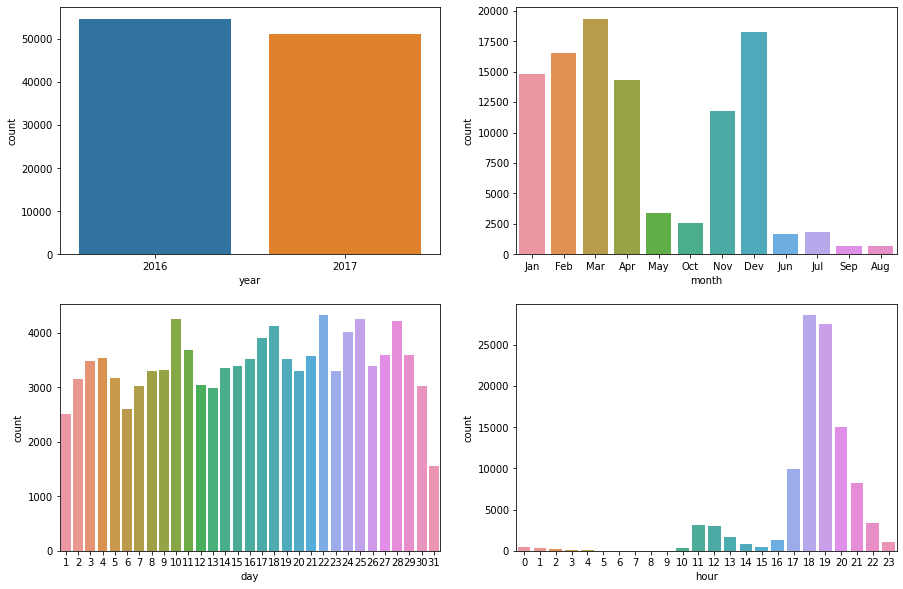

In [ ]:
plt.figure(figsize=(15, 10)) # 방문객수? 예약 횟수? 예약자 수?

plt.subplot(221)
sns.countplot(air['year'])

plt.subplot(222)
sns.countplot(air['month'])

plt.subplot(223)
sns.countplot(air['day'])

plt.subplot(224)
sns.countplot(air['hour'])

In [ ]:
# 요일별 예약 횟수
sns.countplot(air['day_of_week'])

Text(0.5, 1.0, 'Visitor and Reservations')

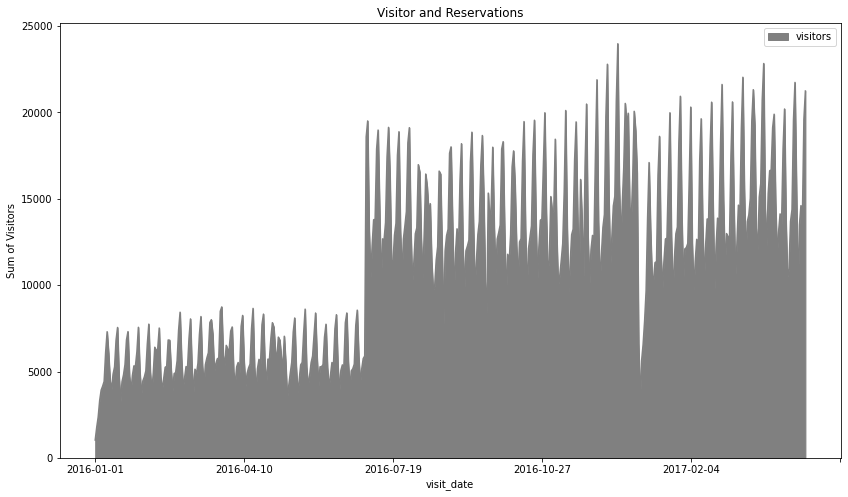

In [ ]:
f,ax = plt.subplots(1,1,figsize=(14,8))
plt1 = air_visits_history.groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt1 = plt1.set_index('visit_date')
plt1.plot(color='gray', kind='area', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

Text(0.5, 1.0, 'Visitor and Reservations')

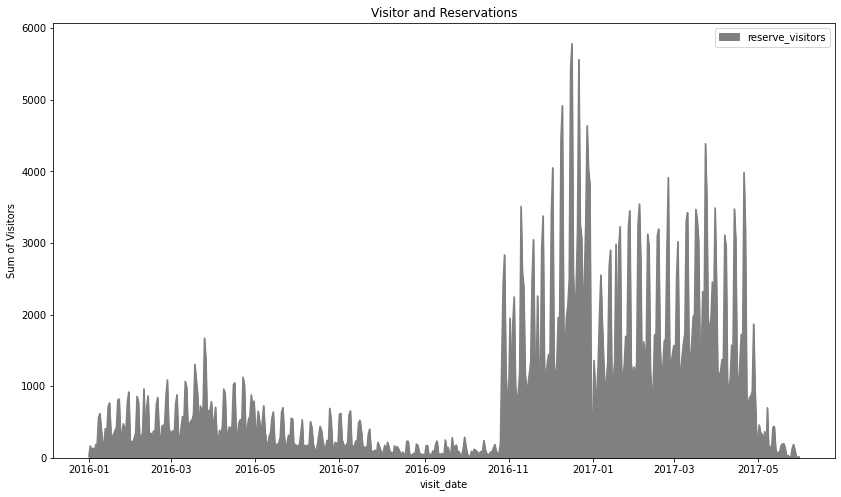

In [ ]:
f,ax = plt.subplots(1,1,figsize=(14,8))
plt1 = air.groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})
plt1 = plt1.set_index('visit_date')
plt1.plot(color='gray', kind='area', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

'air' table의 'year'정보를 가져옴

In [ ]:
air['reserve_visitors'].sum()

480639

Text(0, 0.5, 'reserve_visitors')

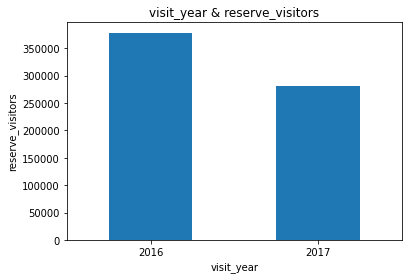

In [ ]:
# 연수별 방문객 수 시각화
# air.groupby('year')['reserve_visitors'].sum().plot.bar(rot=0)
# plt.title("visit_year & reserve_visitors")
# plt.xlabel("visit_year")
# plt.ylabel("reserve_visitors")

Text(0, 0.5, 'reserve_visitors')

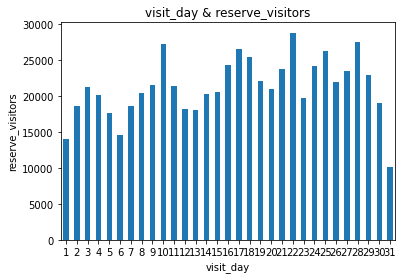

In [ ]:
# air table의 Day별 방문객 수 시각화
# air.groupby('day')['reserve_visitors'].sum().plot.bar(rot=0)
# plt.title("visit_day & reserve_visitors")
# plt.xlabel("visit_day")
# plt.ylabel("reserve_visitors")

Text(0, 0.5, 'reserve_visitors')

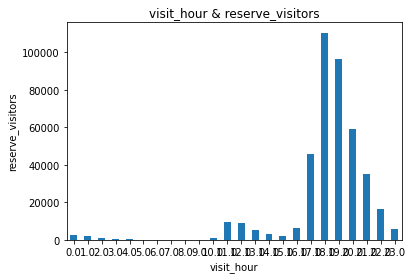

In [ ]:
# air table의 hour별 방문객 수 시각화
# air.groupby('hour')['reserve_visitors'].sum().plot.bar(rot=0)
# plt.title("visit_hour & reserve_visitors")
# plt.xlabel("visit_hour")
# plt.ylabel("reserve_visitors")

인기가 가장 많은 곳: 그래프 크기 조절, 실제 카운트 결과와 그래프 비교

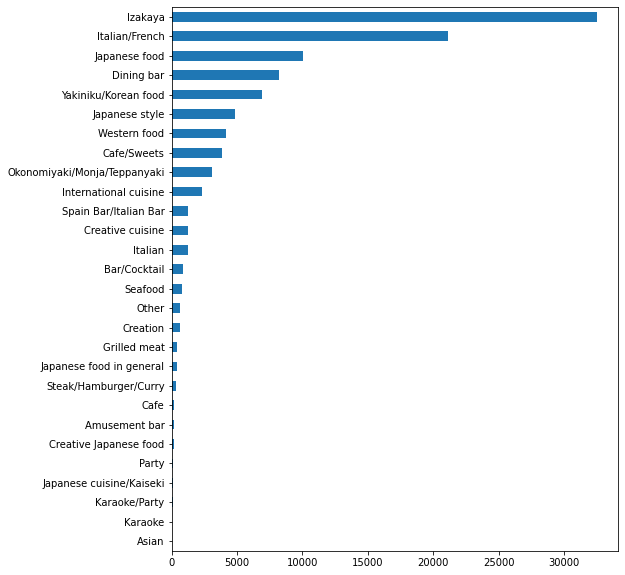

In [ ]:
air.air_genre_name.value_counts().sort_values().plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(8, 10)
plt.show()

In [ ]:
air['air_store_id'].groupby(air['air_genre_name']).count().sort_values(ascending=False)

air_genre_name
Izakaya                         32489
Italian/French                  21106
Japanese food                   10021
Dining bar                       8243
Yakiniku/Korean food             6946
Japanese style                   4878
Western food                     4151
Cafe/Sweets                      3862
Okonomiyaki/Monja/Teppanyaki     3052
International cuisine            2347
Spain Bar/Italian Bar            1291
Creative cuisine                 1270
Italian                          1237
Bar/Cocktail                      910
Seafood                           826
Other                             679
Creation                          618
Grilled meat                      411
Japanese food in general          408
Steak/Hamburger/Curry             344
Cafe                              213
Amusement bar                     168
Creative Japanese food            151
Party                              90
Japanese cuisine/Kaiseki           85
Karaoke/Party                      

In [ ]:
b = air['air_store_id'].groupby(air['todobuken']).count().sort_values(ascending=False)
b.sum() # 총 120561개 = air table의 row 개수

105906

어느 현('todobuken')에 가장 예약 횟수가 많은가

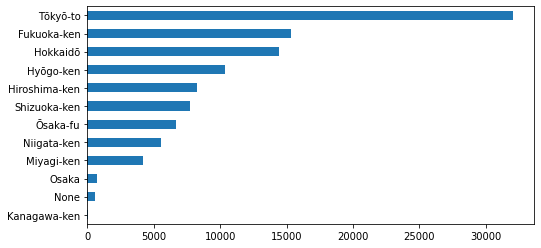

In [ ]:
air.todobuken.value_counts().sort_values().plot(kind='barh')
fig=plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

In [ ]:
air['air_store_id'].groupby(air['todobuken']).count().sort_values(ascending=False)

todobuken
Tōkyō-to         32012
Fukuoka-ken      15362
Hokkaidō         14453
Hyōgo-ken        10343
Hiroshima-ken     8282
Shizuoka-ken      7723
Ōsaka-fu          6698
Niigata-ken       5537
Miyagi-ken        4202
Osaka              713
None               546
Kanagawa-ken        35
Name: air_store_id, dtype: int64

In [ ]:
a = air['air_store_id'].groupby(air['air_genre_name']).count().sort_values(ascending=False)
a.sum() # 총 120561개 = air table의 row 개수

105906

In [ ]:
# tdbk = todobuken
#air_tdbk = air['air_store_id'].groupby(air['todobuken']).count().sort_values(ascending=False)
air_tdbk = air.todobuken.value_counts()

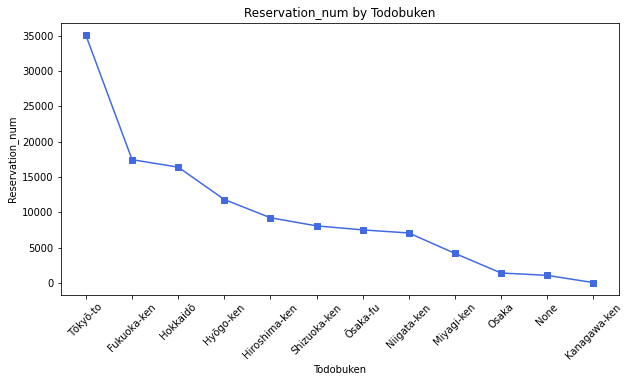

In [ ]:
plt.plot(air_tdbk, color = 'royalblue', marker ='s')
plt.title('Reservation_num by Todobuken')
plt.xlabel('Todobuken')
plt.ylabel('Reservation_num')
plt.xticks(rotation=45)
fig=plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [ ]:
air_tdbk_res= air.groupby('todobuken')['reserve_visitors'].sum().sort_values(ascending=False)
air_tdbk_res

todobuken
Tōkyō-to         131322.0
Fukuoka-ken       75887.0
Hokkaidō          67020.0
Hyōgo-ken         47191.0
Hiroshima-ken     46900.0
Shizuoka-ken      32554.0
Niigata-ken       27796.0
Ōsaka-fu          26237.0
Miyagi-ken        20448.0
Osaka              2807.0
None               2117.0
Kanagawa-ken        360.0
Name: reserve_visitors, dtype: float64

각 todobuken 별 Reserve_visitors 수 비교

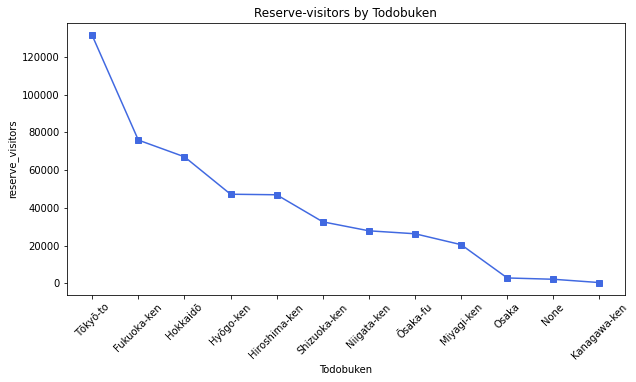

In [ ]:
plt.plot(air_tdbk_res, color = 'royalblue', marker ='s')
plt.title('Reserve-visitors by Todobuken')
plt.xlabel('Todobuken')
plt.ylabel('reserve_visitors')
plt.xticks(rotation=45)
fig=plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

In [ ]:
air.loc[air.holiday_flg == 0, 'holiday_flg'] = 'Non_holiday'
air.loc[air.holiday_flg == 1, 'holiday_flg'] = 'Holiday'

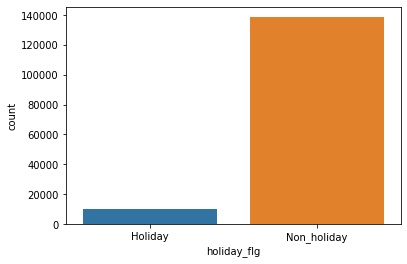

In [ ]:
sns.countplot(x='holiday_flg', data=air)


In [ ]:
c = air.groupby('todobuken')['reserve_visitors'].sum().sort_values(ascending=False)
c.sum()

547263.0

In [ ]:
air['reserve_visitors'].sum() # 

480639

In [ ]:
air_visits_history

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [ ]:
air_visits_history.nunique()

air_store_id    829
visit_date      478
visitors        204
dtype: int64

In [ ]:
air.nunique()

air_store_id         320
visit_datetime      5572
reserve_datetime    8737
reserve_visitors      74
air_genre_name        28
air_area_name        101
latitude             107
longitude            107
day                   31
dow                    7
dow_name               7
year                   2
month                 12
week                  53
quarter                4
visit_date           517
hour                  24
todobuken             12
city                  48
dtype: int64

In [ ]:
import folium
from folium import plugins

In [ ]:
display(air)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour,todobuken,city
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,19,Tōkyō-to,Minato-ku
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,20,Tōkyō-to,Minato-ku
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,18,Tōkyō-to,Minato-ku
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,21,Tōkyō-to,Minato-ku
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,4,Friday,2016,Jan,1,1,2016-01-08,21,Tōkyō-to,Minato-ku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13523,air_465bddfed3353b23,2017-04-10 19:00:00,2017-03-23 20:00:00,23,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924,10,0,Monday,2017,Apr,15,2,2017-04-10,19,Tōkyō-to,Shibuya-ku
13524,air_465bddfed3353b23,2017-04-21 12:00:00,2017-04-17 16:00:00,8,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924,21,4,Friday,2017,Apr,16,2,2017-04-21,12,Tōkyō-to,Shibuya-ku
13525,air_465bddfed3353b23,2017-04-27 18:00:00,2017-04-18 09:00:00,4,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924,27,3,Thursday,2017,Apr,17,2,2017-04-27,18,Tōkyō-to,Shibuya-ku
13526,air_465bddfed3353b23,2017-04-28 19:00:00,2017-04-19 13:00:00,15,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku Ebisunishi,35.646745,139.707924,28,4,Friday,2017,Apr,17,2,2017-04-28,19,Tōkyō-to,Shibuya-ku


In [ ]:
location = air.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139],
                  tiles="Stamen Watercolor",
                  zoom_start=5)

heatmap = plugins.HeatMap(locationheat).add_to(map1)
map1

In [ ]:
location =air.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().dropna(axis=0).reset_index(drop=False)
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()

map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)

marker_cluster=plugins.MarkerCluster().add_to(map2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
location.head(3)

,air_store_id,air_genre_name,latitude,longitude
0,air_00a91d42b08b08d9,Italian/French,35.694003,139.753595
1,air_0164b9927d20bcc3,Italian/French,35.658068,139.751599
2,air_034a3d5b40d5b1b1,Cafe/Sweets,34.692337,135.472229


In [ ]:
for point in range(0, len(location)):
    folium.Marker(locationlist[point], popup=location['air_genre_name'][point], 
    icon=folium.Icon(icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

In [ ]:
air.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
air_genre_name      0
air_area_name       0
latitude            0
longitude           0
day                 0
dow                 0
dow_name            0
year                0
month               0
week                0
quarter             0
visit_date          0
hour                0
todobuken           0
city                0
dtype: int64

# 시각화를 위한 과정

air_visit_data를 시각화

In [ ]:
air_visits_history['visit_date'] = pd.to_datetime(air_visits_history['visit_date'])
air_visits_history['day'] = air_visits_history['visit_date'].dt.day
air_visits_history['dow'] = air_visits_history['visit_date'].dt.weekday
air_visits_history['dow_name'] = air_visits_history['visit_date'].dt.day_name()
air_visits_history['year'] = air_visits_history['visit_date'].dt.year
air_visits_history['month'] = air_visits_history['visit_date'].dt.month
air_visits_history['week'] = air_visits_history['visit_date'].dt.week
air_visits_history['quarter'] = air_visits_history['visit_date'].dt.quarter
air_visits_history['visit_date'] = air_visits_history['visit_date'].dt.date
air_visits_history['year_mth'] = air_visits_history['year'].astype(str)+'-'+air_visits_history['month'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
air_visits_history['dow_name']

0         Wednesday
1          Thursday
2            Friday
3          Saturday
4            Monday
            ...    
252103      Tuesday
252104    Wednesday
252105     Thursday
252106       Friday
252107     Saturday
Name: dow_name, Length: 252108, dtype: object

In [ ]:
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')))
test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['day'] = test['visit_date'].dt.day
test['dow'] = test['visit_date'].dt.weekday
test['dow_name'] = test['visit_date'].dt.day_name()
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['week'] = test['visit_date'].dt.week
test['quarter'] = test['visit_date'].dt.quarter
test['visit_date'] = test['visit_date'].dt.date
test['year_mth'] = test['year'].astype(str)+'-'+test['month'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [ ]:
unique_stores = test['air_store_id'].unique()

In [ ]:
store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, \
                                       'dow': [i]*len(unique_stores)}) \
                         for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [ ]:
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [ ]:
tmp = air_visits_history.groupby(['air_store_id'], as_index=False)['visitors'].sum().rename(columns={'visitors': 'total_visitors'})

In [ ]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = air_visits_history.groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})

store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})

store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})

store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})

store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})

store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 
# map stores(test) to store genre and location detail
store_7days = pd.merge(store_7days, air_store_info, how='left', on=['air_store_id']) 
#map to hpg genre and area
store_7days = pd.merge(store_7days, hpg_store_info['air_store_id','hpg_genre_name','hpg_area_name'], 
                       how='left', on=['air_store_id']) 

KeyError: ignored

------


In [ ]:
air.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour,todobuken,city
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,19,Tōkyō-to,Minato-ku
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,20,Tōkyō-to,Minato-ku
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,18,Tōkyō-to,Minato-ku


In [ ]:
hpg.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_a24bf50c3e90d583,2016-01-06 19:00:00,2016-01-06 13:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
1,air_a24bf50c3e90d583,2016-01-07 21:00:00,2016-01-03 19:00:00,6,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944
2,air_a24bf50c3e90d583,2016-01-08 19:00:00,2016-01-07 14:00:00,2,Italian,Shizuoka-ken Hamamatsu-shi Sukenobuchō,34.721644,137.738944


In [ ]:
air_visits_history.head()

,air_store_id,visit_date,visitors,day,dow,dow_name,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,Wednesday,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,Thursday,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,Friday,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,Saturday,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,Monday,2016,1,3,1,2016-1


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


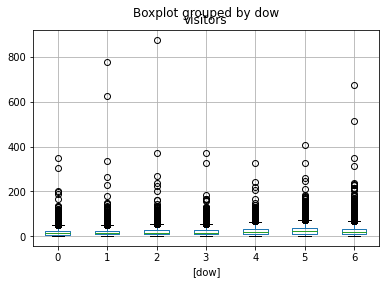

In [ ]:
air_visits_history[['dow', 'visitors']].boxplot(by='dow') # 0: Monday

In [ ]:
over_visitor = air_visits_history.loc[air_visits_history["visitors"] > 100]
over_visitor.count() # 가계에 방문자수가 100이 넘는 곳

air_store_id    509
visit_date      509
visitors        509
day             509
dow             509
dow_name        509
year            509
month           509
week            509
quarter         509
year_mth        509
dtype: int64

In [ ]:
#air_visits_history과 air_store_info를 조인하여 지역별 방문자 수 boxplot 그려볼것!
visit_store = pd.merge(air_visits_history, air_store_info, on = 'air_store_id', how='inner')

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


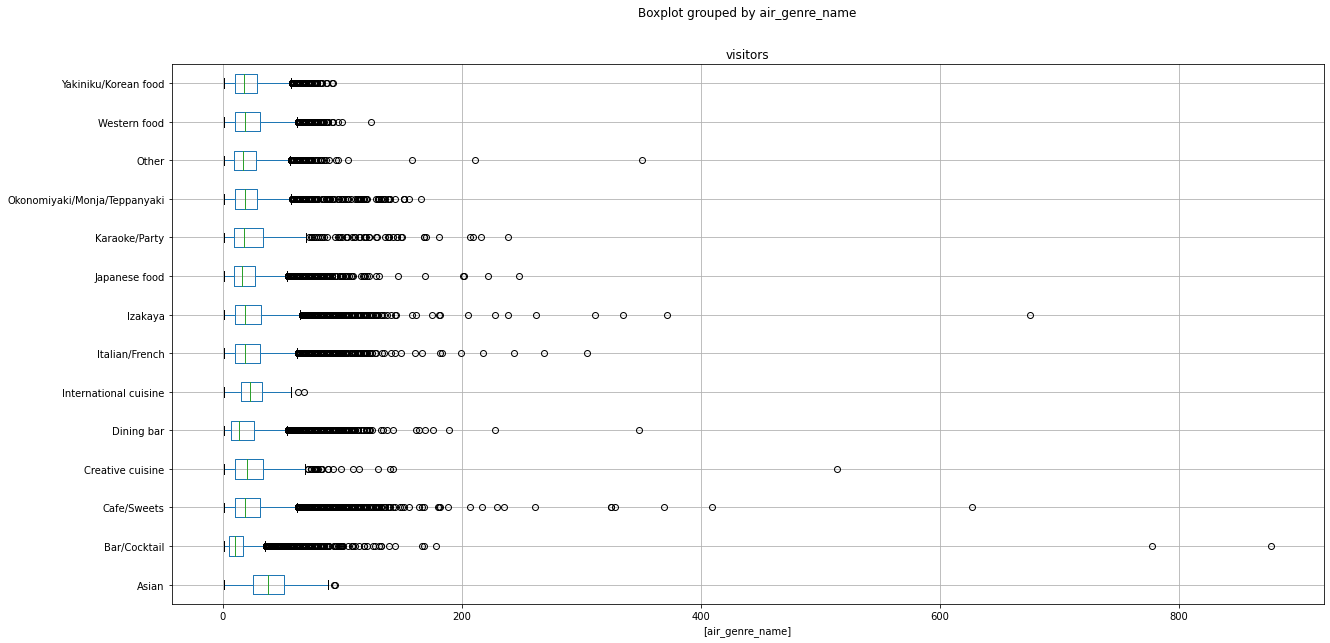

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
boxplot=visit_store[['air_genre_name', 'visitors']].boxplot(by = 'air_genre_name',vert=False) # 축 변경 True 세로 => default
plt.show()

In [ ]:
area_split = visit_store['air_area_name'].str.split(" ")

visit_store["todobuken"] = area_split.str.get(0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


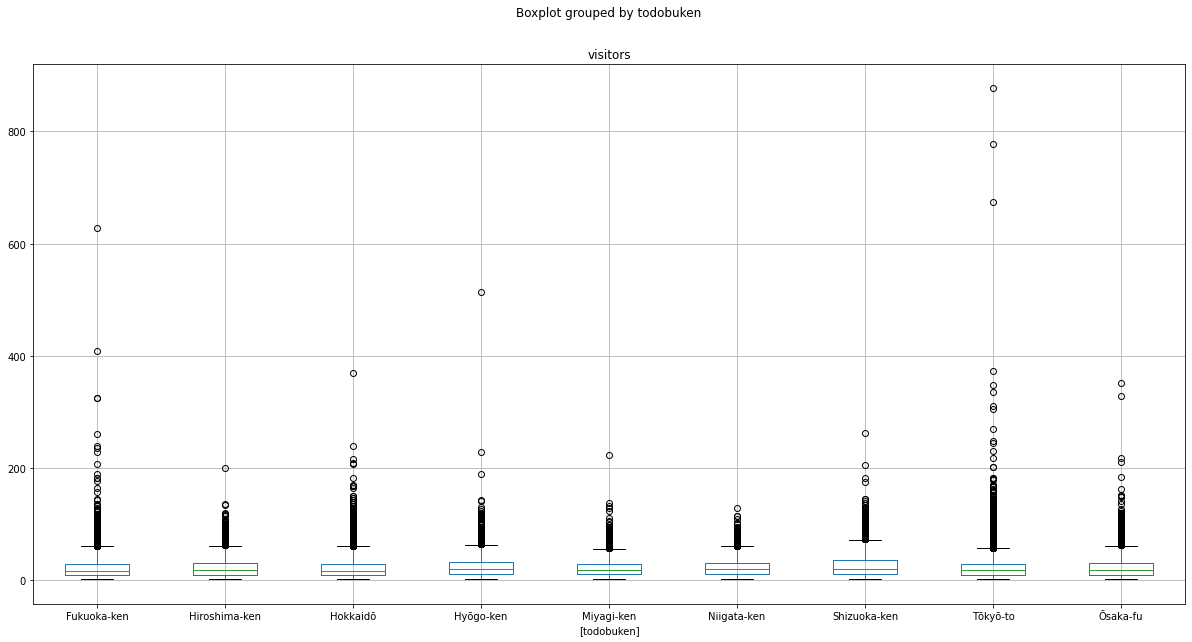

In [ ]:
visit_store[['todobuken', 'visitors']].boxplot(by = 'todobuken')

In [ ]:
visit_store.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,todobuken
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to


In [ ]:
air.head() 

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day,dow,dow_name,year,month,week,quarter,visit_date,hour,todobuken,city
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,19,Tōkyō-to,Minato-ku
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,4,Friday,2016,Jan,53,1,2016-01-01,20,Tōkyō-to,Minato-ku
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,18,Tōkyō-to,Minato-ku
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,5,Saturday,2016,Jan,53,1,2016-01-02,21,Tōkyō-to,Minato-ku
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,8,4,Friday,2016,Jan,1,1,2016-01-08,21,Tōkyō-to,Minato-ku


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


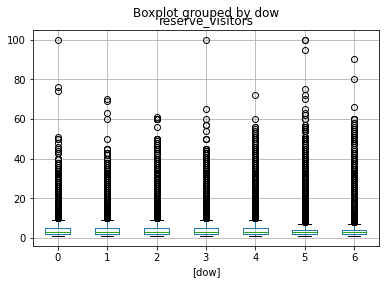

In [ ]:
air[['reserve_visitors', 'dow']].boxplot(by='dow')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


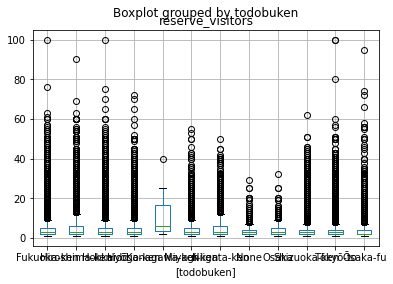

In [ ]:
air[['todobuken', 'reserve_visitors']].boxplot(by='todobuken')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


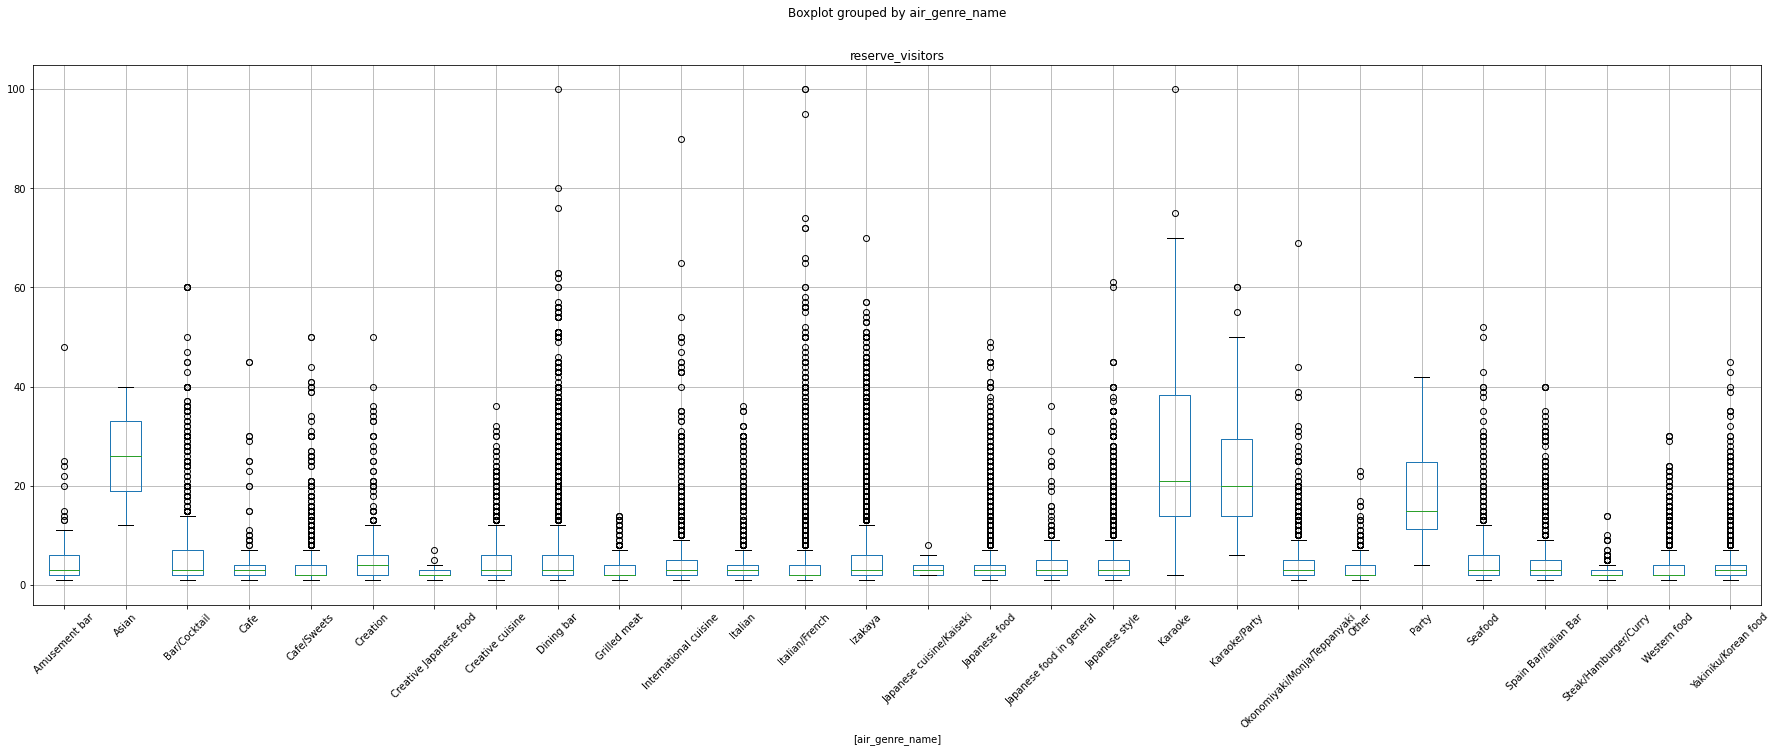

In [ ]:
plt.rcParams['figure.figsize']=(30,10)
boxplot=air[['air_genre_name', 'reserve_visitors']].boxplot(by = 'air_genre_name')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


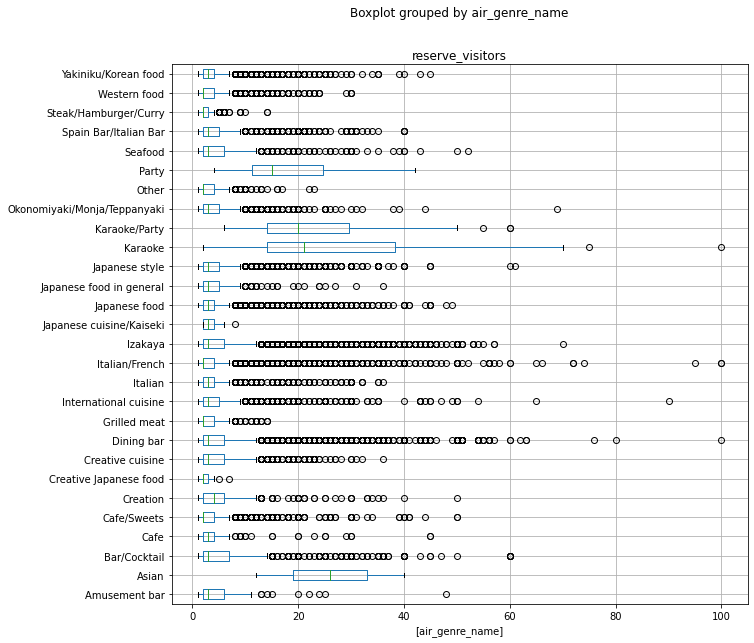

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
boxplot=air[['air_genre_name', 'reserve_visitors']].boxplot(by = 'air_genre_name',vert=False) # 축 변경 True 세로 => default
plt.show()

-------

train set 구성 : https://www.kaggle.com/tunguz/surprise-me-2 https://www.kaggle.com/shikhar1/combining-tables-and-data-pre-processing

Train, test 초기 테이블 생성

In [ ]:
# air_visits_history 테이블에 필요한 columns 추가하기
# air_visits_history 테이블이 train set의 base가 된다
air_visits_history['visit_date'] = pd.to_datetime(air_visits_history['visit_date'])
air_visits_history['dow'] = air_visits_history['visit_date'].dt.dayofweek
air_visits_history['year'] = air_visits_history['visit_date'].dt.year
air_visits_history['month'] = air_visits_history['visit_date'].dt.month
air_visits_history['visit_date'] = air_visits_history['visit_date'].dt.date

# test 테이블에 마찬가지로 colomns 추가하기
# test 의 'id'를 'visit_date'와 'air_store_id'로 나눠서 column으로 입력
# test 테이블이 test set의 base가 된다
test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['dow'] = test['visit_date'].dt.dayofweek
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['visit_date'] = test['visit_date'].dt.date

In [ ]:
# sample_submission(test)의 unique store 가 어떤것들이 있는지 확인
# 여기 있는 store들을 가지고 최종 test를 해야 하기 때문에 구분하는 듯
unique_stores = test['air_store_id'].unique()

# 전체 stores중에 해당 unique_stores에 dow를 추가하는 것으로 생각 됨
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
stores

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0
...,...,...
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6


In [ ]:
# 위에서 만든 stores에 air_visits_history의 visitors에 대한 min, mean, median, max, count_observation값을 추가
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = air_visits_history.groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
stores